In [31]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext dotenv
%dotenv ../.env

In [3]:
cnx = create_engine(os.getenv('EDMDB'))

#### PLUTO and building footprints comparison. Create supporting dataframes

Create dataframes of bldgclass and landuse definitions

In [4]:
bldgclass_def = pd.read_sql_query('''SELECT * FROM dcp.bldgclass_definitions;''', cnx)
landuse_def = pd.read_sql_query('''SELECT * FROM dcp.landuse_definitions;''', cnx)
landuse_def

,landuse,def
0,01,One and Two Family Buildings
1,02,Multi-Family Walkup Buildings
2,03,Multi-Family Elevator Buildings
3,04,Mixed Residential and Commercial
4,05,Commercial and Office
5,06,Industrial and Manufacturing
6,07,Transportation and Utility
7,08,Public Facilities and Institutions
8,09,Open Space and Outdoor Recreation
9,10,Parking Facilities


Find lots where building footprints does not have the same number of buildings as PLUTO.

In [5]:
df = pd.read_sql_query('''WITH footprints_count_by_bbl AS (
	SELECT mpluto_bbl,
	COUNT(*) AS bldg_footprints_count
	FROM dcp.bldg_footprints
	GROUP BY mpluto_bbl
)
SELECT CAST(bbl AS TEXT),
borough,
address, 
landuse,
bldgclass,
ownername,
numbldgs,
bldg_footprints_count, 
numbldgs - bldg_footprints_count AS difference
FROM dcp.pluto201, footprints_count_by_bbl
WHERE bbl = CAST(mpluto_bbl AS NUMERIC)
AND numbldgs <> bldg_footprints_count
ORDER BY difference DESC;''', cnx)
df.head()

,bbl,borough,address,landuse,bldgclass,ownername,numbldgs,bldg_footprints_count,difference
0,4163500300,QN,None,01,A8,BREEZY POINT COOPERA,795,518,277
1,4142600001,QN,154-68 BROOKVILLE BOULEVARD,07,T1,PORT AUTHORITY OF NY AND NJ,422,246,176
2,4163500400,QN,None,01,A8,"BREEZY POINT COOPERATIVE, INC",1861,1720,141
3,4163400050,QN,1 ROCKAWAY POINT BLVD,01,A8,BREEZY POINT CO-OP,515,404,111
4,5021400027,SI,1A DINSMORE STREET,09,Q3,RUSTIC WOODS HOMEOWNERS ASSOC INC,82,1,81


#### Questions

How many lots have differences in counts?

In [6]:
df.shape[0]

20673

How often does PLUTO have greater numbers?

In [7]:
more_bldgs_on_pluto = df[(df['numbldgs'] > df['bldg_footprints_count'])]
more_bldgs_on_pluto.shape[0]

16616

How often does building footprints have greater numbers?

In [8]:
more_bldgs_on_footprints = df[(df['numbldgs'] < df['bldg_footprints_count'])]
more_bldgs_on_footprints.shape[0]

4057

Does the landuse code tell us anything interesting?

In [9]:
landuse_counts = df['landuse'].value_counts()
landuse_dist = pd.DataFrame({'landuse':landuse_counts.index, 'count':landuse_counts.values})
landuse_dist = pd.merge(landuse_dist, landuse_def, how='left', on=['landuse'])
landuse_dist

,landuse,count,def
0,01,12953,One and Two Family Buildings
1,02,3034,Multi-Family Walkup Buildings
2,04,1226,Mixed Residential and Commercial
3,08,688,Public Facilities and Institutions
4,05,617,Commercial and Office
5,07,458,Transportation and Utility
6,11,386,Vacant Land
7,06,382,Industrial and Manufacturing
8,03,373,Multi-Family Elevator Buildings
9,10,224,Parking Facilities


What about the building class?

In [10]:
bldgclass_counts = df['bldgclass'].str.slice(0, 1).value_counts()
bldgclass_dist = pd.DataFrame({'bldgclass':bldgclass_counts.index, 'count':bldgclass_counts.values})
bldgclass_dist = pd.merge(bldgclass_dist, bldgclass_def, how='left', on=['bldgclass'])
bldgclass_dist

,bldgclass,count,descr
0,A,7068,One Family Dwellings
1,B,5877,Two Family Dwellings
2,C,2468,Walk-Up Apartments
3,R,997,Condominiums
4,S,641,Residence - Multiple Use
5,G,523,Garages and Gasoline Stations
6,K,483,Store Buildings (Taxpayers Included)
7,V,386,Vacant Land
8,D,373,Elevator Apartments
9,M,277,Churches and Synagogues


In [11]:
df.to_csv('../output/Building_Count_Discrepancies.csv')

Distribution by borough

In [12]:
boro_counts = df['borough'].value_counts()
boro_dist = pd.DataFrame({'borough':boro_counts.index, 'count':boro_counts.values})
boro_dist

,borough,count
0,QN,7593
1,BK,6268
2,SI,3908
3,BX,2170
4,MN,734


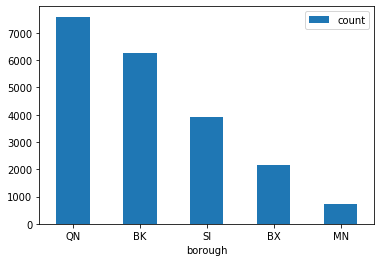

In [13]:
ax = boro_dist.plot.bar(x='borough', y='count', rot=0)

In [19]:
difference_counts = df['difference'].value_counts()
difference_dist = pd.DataFrame({'difference':difference_counts.index, 'count':difference_counts.values})
difference_dist.sort_values(by='count', ascending=False, inplace=True)
difference_dist

,difference,count
0,1,15714
1,-1,3346
2,2,561
3,-2,237
4,3,151
...,...,...
90,-128,1
91,-80,1
92,-48,1
94,-196,1


In [26]:
difference_dist['difference'].describe()

count    122.000000
mean     -36.245902
std       64.931281
min     -226.000000
25%      -71.750000
50%      -33.500000
75%       -3.250000
max      277.000000
Name: difference, dtype: float64

Text(0, 0.5, 'Frequency')

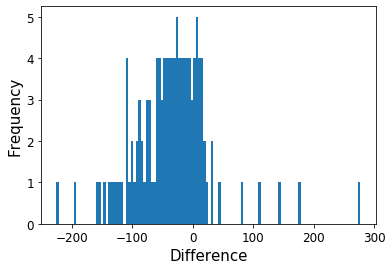

In [29]:
bins = difference_dist.shape[0]
difference_dist['difference'].hist(bins=bins, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Difference", fontsize=15)
plt.ylabel("Frequency",fontsize=15)

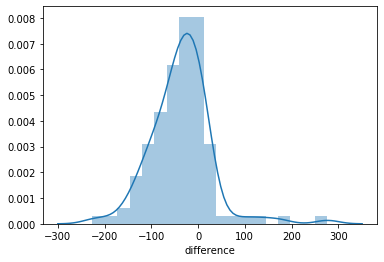

In [32]:
sns.distplot(difference_dist['difference'])